#### Implementation from scratch d'un perceptron multicouche only numpy + maths ;)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
np.set_printoptions(suppress=True)


##### 1. Definiton du réseau et initialisation des poids

In [3]:
# Initialisation des poids et des biais...
def initialisation_des_poids(entre_taille, cache_taille, sortie_taille):
    W = np.random.normal(0, 0.1, (cache_taille, entre_taille))
    b = np.zeros((cache_taille, 1))
    Ws = np.random.normal(0, 0.1, (sortie_taille, cache_taille))
    bs = np.zeros((sortie_taille, 1))

    return W, b, Ws, bs

In [4]:
# Fonction d'activation ReLU pour les couches cachées
def ReLU(Z):
    return np.maximum(Z, 0)

In [5]:
# Dérivée de la fonction d'activation ReLU (pour le backpropagation)
# Encore appelée fonction seuil ou hearviside.
def dReLU(Z):
    return np.where(Z > 0, 1.0, 0.0)

In [6]:
# Utilisation de softmax sur la couche de sortie pour obtenir les probabilités
def softmax(Ypred):
    exp_Ypred = np.exp(Ypred - np.max(Ypred))
    return exp_Ypred / np.sum(exp_Ypred, axis=0)

In [7]:
# Pour dessiner notre courbe d'apprentissage
def dessiner_courbe_dapprentissage(erreurs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(erreurs)), erreurs)
    plt.ylim(0, 1)
    plt.xlim(0, len(erreurs)-1)
    plt.xlabel("Itérations")
    plt.ylabel("Erreurs")
    plt.show()

##### 2. Propagation avant (FORWARD PROPAGATION)

In [8]:
# Propagation avant qui prend en entrée les données, les poids et les biais
def propagation_avant(X, W, b, Ws, bs):
    Z = np.dot(W, X) + b
    H = ReLU(Z)
    Zs = np.dot(Ws, H) + bs
    Ypred = softmax(Zs)
    
    return Z, H, Ypred

In [9]:
# Fonction de prédiction dans laquelle on utilise les poids et les biais appris 
def predict(X, Wc, bc, Ws, bs):
    _, _, Ypred = propagation_avant(X.T, Wc, bc, Ws, bs)
    return Ypred

##### 3. Calcul de la perte avec l'entropie croisée

In [10]:
# Calcul de la perte L avec la fonction de coût entropie croisée dans la classification multiclasse
# L = -1/N * somme(Ytrue * log(Ypred))
def L(Ypred, Ytrue):
    return -np.mean(np.sum(Ytrue * np.log(Ypred), axis=0))

##### 4. Rétropropagation (Propagation arriere)

In [11]:
# Propagation arriere qui prend en entrée les predictions, les valeurs vraies, la sortie de la couche cachée etc...
def propagation_arriere(Ypred, Ytrue, X, Z, H, Ws):
    # Calcul du gradient pour la souche de sortie Zs :

    dZs = Ypred - Ytrue
    dWs = np.dot(dZs, H.T) / X.shape[1]
    dbs = np.sum(dZs, axis=1, keepdims=True) / X.shape[1]

    # Calcul du gradient pour la couche cachée Z :
    dH = np.dot(Ws.T, dZs)
    dZ = dH * dReLU(Z) 
    dW = np.dot(dZ, X.T)
    db = np.sum(dZ, axis=1, keepdims=True) / X.shape[1]

    return dW, db, dWs, dbs


##### 5. Mise a jour des poids (Descente de gradient)

In [12]:
# Mise a jour des poids et biais qui prend en entrée les ancients poids, les gradients calculés plus haut et le learning rate lr
# et on met a jour les poids avec la regle de descente de gradient : W = W - lr*dW
def mise_a_jour(W, b, Ws, bs, dW, db, dWs, dbs, lr):
    W = W - lr*dW
    b = b - lr*db

    Ws = Ws - lr*dWs
    bs = bs - lr*dbs

    return W, b, Ws, bs

In [24]:
# Fonction d'entrainement qui prend en entrée les données, les valeurs vraies, le nombre de neurones de la couche cachée, le learning rate et le nombre d'itérations
def apprentissage(X, Y, iterations, lr, cache_taille):
    entre_taille = X.shape[0]
    sortie_taille = Y.shape[0]

    W, b, Ws, bs = initialisation_des_poids(entre_taille, cache_taille, sortie_taille)
    erreurs = []

    for i in range(iterations):
        Z, H, Ypred = propagation_avant(X, W, b, Ws, bs)
        erreur = L(Ypred, Y)
        erreurs.append(erreur)

        dW, db, dWs, dbs = propagation_arriere(Ypred, Y, X, Z, H, Ws)
        W, b, Ws, bs = mise_a_jour(W, b, Ws, bs, dW, db, dWs, dbs, lr)

    dessiner_courbe_dapprentissage(erreurs)
    return W, b, Ws, bs    

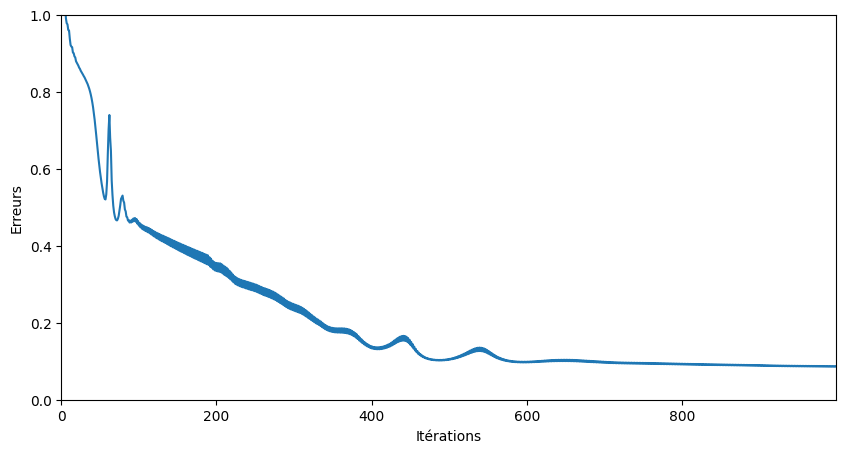

In [34]:
# Chargement du jeu de données Iris
iris = load_iris()
X = iris.data  # (150, 4) - 150 échantillons, 4 caractéristiques
Y = iris.target.reshape(1, -1)  # (1, 150)

# Encodage One-Hot des étiquettes
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.T)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

# Entraînement du modèle
W, b, Ws, bs = apprentissage(X_train.T, Y_train.T, 1000, 0.01, 10)

In [35]:
 # Test du modèle 
Ypred = predict(X_test, W, b, Ws, bs)
erreur = L(Ypred, Y_test.T)

# Erreur
print(f"Erreur sur l'ensemble de test : {erreur:.4f}")

# Accuracy
accuracy = np.mean(np.argmax(Ypred, axis=0) == np.argmax(Y_test.T, axis=0))
print(f"Accuracy : {accuracy * 100:.2f}%")

Erreur sur l'ensemble de test : 0.0724
Accuracy : 100.00%


In [36]:
# Sauvegarder mon modele avec pickle
with open("iris_model.pkl", "wb") as f:
    pickle.dump((W, b, Ws, bs), f)

In [37]:
# Afin d'obtenir le nom de l'espece a partir de la prediction du modele.
def obtenir_espece_iris(Ypred):
    classes = ["Setosa", "Versicolor", "Virginica"]
    return classes[np.argmax(Ypred)]

In [38]:
# Fonction pour répondre avec les détails de l'iris, type prédit inclus.
def repondre_iris(features):
    longeur_sepale, largeur_sepale, longeur_petale, largeur_petale = features
    x = np.asmatrix([features])
    
    with open("iris_model.pkl", "rb") as f:
        W, b, Ws, bs = pickle.load(f)
    
    # Prédire
    Ypred = predict(x, W, b, Ws, bs)
    espece = obtenir_espece_iris(Ypred)
    
    return {
        "spH": longeur_sepale,
        "spW": largeur_sepale,
        "ptH": longeur_petale,
        "ptW": largeur_petale,
        "specie": espece
    }

In [39]:
print(repondre_iris([4.9, 3.1, 1.5, 0.2])) # Setosa
print(repondre_iris([5.7, 2.8, 4.1, 1.3])) # Versicolor
print(repondre_iris([6.2, 3.4, 5.4, 2.3])) # Virginica

{'spH': 4.9, 'spW': 3.1, 'ptH': 1.5, 'ptW': 0.2, 'specie': 'Setosa'}
{'spH': 5.7, 'spW': 2.8, 'ptH': 4.1, 'ptW': 1.3, 'specie': 'Versicolor'}
{'spH': 6.2, 'spW': 3.4, 'ptH': 5.4, 'ptW': 2.3, 'specie': 'Virginica'}
